<a href="https://colab.research.google.com/github/DanhKiD/Bot_GAN/blob/main/Bot_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.activations import sigmoid
from keras.backend import binary_crossentropy
from keras.layers import Input, Dense, Activation, dense_attention
from keras.layers.merge import Maximum, Concatenate
from keras.models import Model
from keras.optimizers import Adam
from numpy.lib.function_base import blackman

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import linear_model, svm, tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
#from VOTEClassifier import VOTEClassifier

In [2]:
class BotGAN():
    def __init__(self, blackbox='RF', same_train_data=1, filename='/content/drive/MyDrive/Dataset/train.csv') -> None:
        self.apifeatures_dims = 53
        self.z_dims = 10
        self.hide_layers = 256
        self.generator_layers = [self.apifeatures_dims + self.z_dims, self.hide_layers, self.apifeatures_dims]
        self.substitue_detector_layers = [self.apifeatures_dims, self.hide_layers, 1]
        self.blackbox = blackbox  # RF, LR, DT, SVM, MLP, VOTE
        self.same_train_data = same_train_data # BotGAN and the blackbox_detector are trained on same or different training set
        optimizer = Adam(learning_rate=0.001)
        self.filename = filename

        # Build and Train blackbox_detector
        self.blackbox_detector = self.build_blackbox_detector()

        # Build and compile the substitute_detector
        self.substitue_detector = self.build_substitute_detector()
        self.substitue_detector.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        #The generator takes botnet and noise as input and generates adversarial botnet examples
        examples = Input(shape=(self.apifeatures_dims,))
        noise = Input(shape=(self.z_dims,))
        input = [examples, noise]
        botnet_examples = self.generator(input)

        # For the combine model we will only train the generator
        self.substitue_detector.trainable = False

        # The discriminator takes generated botnet as input an determines validity
        validity = self.substitue_detector(botnet_examples)

        # The combine model (stacked generator and substitute_detector)
        # Trains the generator to fool the discriminator
        self.combine = Model(input, validity)
        self.combine.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    def build_blackbox_detector(self):
        blackbox_detector = None
        if self.blackbox == 'RF':
            blackbox_detector = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=1)
        elif self.blackbox == 'SVM':
            blackbox_detector = svm.SVC()
        elif self.blackbox == 'LR':
            blackbox_detector = linear_model.LogisticRegression()
        elif self.blackbox == 'DT':
            blackbox_detector = tree.DecisionTreeRegressor()
        elif self.blackbox == 'MLP':
            blackbox_detector = MLPClassifier(hidden_layer_sizes=(10,), max_iter=10, alpha=1e-1,
                                solver='sgd', verbose=0, tol=1e-4, random_state=1,
                                learning_rate_init=.1)
        elif self.blackbox == 'GBC':
            blackbox_detector = GradientBoostingClassifier(learning_rate=0.01, n_estimators=100, random_state=1)
        elif self.blackbox == 'KNC':
            blackbox_detector = KNeighborsClassifier(n_neighbors=10)
        #elif self.blackbox == 'VOTE':
        #    blackbox_detector = VOTEClassifier()
        
        return blackbox_detector

    def build_generator(self):
        examples = Input(shape=(self.apifeatures_dims,))
        noise = Input(shape=(self.z_dims,))
        x = Concatenate(axis=1)([examples, noise])
        for dim in self.generator_layers[1:]:
            x = Dense(dim)(x)
        x = Activation(activation='sigmoid')(x)
        x = Maximum()([examples, x])
        generator = Model([examples, noise], x, name='generator')
        generator.summary()

        return generator

    def build_substitute_detector(self):
        input = Input(shape=(self.substitue_detector_layers[0],))
        x = input
        for dim in self.substitue_detector_layers[1:]:
            x = Dense(dim)(x)
        x = Activation(activation='sigmoid')(x)
        substitute_detector = Model(input, x, name='substitute_detector')
        substitute_detector.summary()

        return substitute_detector

    def preprocessing(self):
        # Load dataset
        data = pd.read_csv(self.filename)
        
        # Drop unnecessary columns
        data.drop(["pkSeqID","seq","subcategory", "category"], axis=1, inplace=True)
        
        # Convert source port from hex to dec
        data['sport']=data['sport'].replace(['0x0303'],'771') 
        data['sport']=data['sport'].replace(['0x0011'],'17')
        data['sport']=data['sport'].replace(['0x000d'],'13')
        data['sport']=data['sport'].replace(['0x0008'],'8')

        # Change type from object to int
        data["sport"] = data["sport"].astype(str).astype(int)

        # Encoding data
        le = LabelEncoder()
        data["saddr_enc"]= le.fit_transform(data.saddr)
        data["daddr_enc"]= le.fit_transform(data.daddr)
        data["proto_enc"]= le.fit_transform(data.proto)
        data.drop(['saddr','daddr','proto'], axis=1, inplace=True)

        # Convert dest port from hex to dec
        data['dport']=data.dport.apply(lambda x: int(x,16) if len(x)>1 and x[1]=="x" else int(x))

        # Swap label to end
        titles = list(data.columns)
        titles[11], titles[14] = titles[14], titles[11]
        data = data[titles]
        del titles
        # Scale dataset
        label = data['attack']
        scaler=StandardScaler()
        features = data.iloc[:,:-1]
        cols=features.columns
        scaled_features= scaler.fit_transform(features)
        pre_data = pd.DataFrame(scaled_features,columns=cols)
        pre_data['attack'] = label.values
        del label
        
        return pre_data

    def load_data(self):
        #data = self.preprocessing()
        data = pd.read_csv('/content/drive/MyDrive/Dataset/train.csv')
        ynor = np.array(data[data['label'] == 0]['label'])
        ybot = np.array(data[data['label'] == 1]['label'])
        xnor = np.array(data[data['label'] == 0].iloc[:, :-1])
        xbot = np.array(data[data['label'] == 1].iloc[:, :-1])
        #xbot = data.loc[np.random.choice(data[data['attack'] == 1].index.values, 1148)].iloc[:, :-1]
        
        return (xbot, ybot), (xnor, ynor)

    def train(self, epochs, batch_size=32, is_first=1):
        # Load and split the dataset
        (xbot, ybot), (xnor, ynor) = self.load_data()
        xtrain_bot, xtest_bot, ytrain_bot, ytest_bot = train_test_split(xbot, ybot, test_size=0.3)
        xtrain_nor, xtest_nor, ytrain_nor, ytest_nor = train_test_split(xnor, ynor, test_size=0.3)
        if self.same_train_data:
            bl_xtrain_bot, bl_ytrain_bot, bl_xtrain_nor, bl_ytrain_nor = xtrain_bot, ytrain_bot, xtrain_nor, ytrain_nor
        else:
            xtrain_bot, bl_xtrain_bot, ytrain_bot, bl_ytrain_bot = train_test_split(xtrain_bot, ytrain_bot, test_size=0.5)
            xtrain_nor, bl_xtrain_nor, ytrain_nor, bl_ytrain_nor = train_test_split(xtrain_nor, ytrain_nor, test_size=0.5)
        
        # If is_first is True, train the blackbox_detector
        if is_first:
            self.blackbox_detector.fit(np.concatenate([xbot, xnor]), 
                                    np.concatenate([ybot, ynor]))

        ytrain_nor_blackbox = self.blackbox_detector.predict(bl_xtrain_nor)
        Original_Train_TPR = self.blackbox_detector.score(bl_xtrain_bot, bl_ytrain_bot)
        Original_Test_TPR = self.blackbox_detector.score(xtest_bot, ytest_bot)
        Train_TPR, Test_TPR = [Original_Train_TPR], [Original_Test_TPR]
        best_TPR = 1.0
        print(Train_TPR, Test_TPR, '\n')
        print('Training epochs.....')
        for epoch in range(epochs):
            for step in range(xtrain_bot.shape[0] // batch_size):
                # Train substitute_detector

                # Select a random batch of botnet examples
                idx = np.random.randint(0, xtrain_bot.shape[0], batch_size)
                xbot_batch = xtrain_bot[idx]
                noise = np.random.uniform(0, 1, (batch_size, self.z_dims))
                idx = np.random.randint(0, xbot_batch.shape[0], batch_size)
                xnor_batch = xtrain_nor[idx]
                ynor_batch = ytrain_nor_blackbox[idx]

                # Generate a batch of new malware examples
                gen_examples = self.generator.predict([xnor_batch, noise])
                ybot_batch = self.blackbox_detector.predict(np.ones(gen_examples.shape)*(gen_examples > 0.5))

                # Train the substitute_detector
                d_loss_real = self.substitue_detector.train_on_batch(gen_examples, ybot_batch)
                d_loss_fake = self.substitue_detector.train_on_batch(xnor_batch, ynor_batch)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # Train Generator
                idx = np.random.randint(0, xtrain_bot.shape[0], batch_size)
                xbot_batch = xtrain_bot[idx]
                noise = np.random.uniform(0, 1, (batch_size, self.z_dims))

                g_loss = self.combine.train_on_batch([xbot_batch, noise], np.zeros((batch_size, 1)))
            
            # Compute Train TPR
            noise = np.random.uniform(0, 1, (xtrain_bot.shape[0], self.z_dims))
            gen_examples = self.generator.predict([xtrain_bot, noise])
            TPR = self.blackbox_detector.score(np.ones(gen_examples.shape) * (gen_examples > 0.5), ytrain_bot)
            Train_TPR.append(TPR)

            # Compute Test TPR
            noise = np.random.uniform(0, 1, (xtest_bot.shape[0], self.z_dims))
            gen_examples = self.generator.predict([xtest_bot, noise])
            TPR = self.blackbox_detector.score(np.ones(gen_examples.shape) * (gen_examples > 0.5), ytest_bot)
            Test_TPR.append(TPR)
            print(Train_TPR[-1], Test_TPR[-1])

            # Save best model
            if TPR < best_TPR:
                self.combine.save_weights('/content/drive/MyDrive/Dataset/saves/BotGAN.h5')
                best_TPR = TPR
            
            # Plot the progress
            if is_first:
                print("%d [D loss: %f, acc.: %.4f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
        
        flag = ['DiffTrainData', 'SameTrainData']
        print('\n\n---{0} {1}'.format(self.blackbox, flag[self.same_train_data]))
        print('\nOriginal_Train_TPR: {0}, Adver_Train_TPR: {1}'.format(Original_Train_TPR, Train_TPR[-1]))
        print('\nOriginal_Test_TPR: {0}, Adver_Test_TPR: {1}'.format(Original_Test_TPR, Test_TPR[-1]))

        # Plot TPR
        plt.figure()
        plt.plot(range(len(Train_TPR)), Train_TPR, c='r', label='Training Set', linewidth=2)
        plt.plot(range(len(Test_TPR)), Test_TPR, c='g', linestyle='--', label='Validation Set', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('TPR')
        plt.legend()
        plt.savefig('/content/drive/MyDrive/Dataset/saves/Epoch_TPR_{0}, {1}, {2}.png'.format(self.blackbox, flag[self.same_train_data], is_first))
        plt.show()

    def retrain_blackbox_detector(self):
        (xbot, ybot), (xnor, ynor) = self.load_data()
        xtrain_bot, xtest_bot, ytrain_bot, ytest_bot = train_test_split(xbot, ybot, test_size=0.2)
        xtrain_nor, xtest_nor, ytrain_nor, ytest_nor = train_test_split(xnor, ynor, test_size=0.2)

        # Generate Train Adversarial Examples
        noise = np.random.uniform(0, 1, (xtrain_bot.shape[0], self.z_dims))
        gen_examples = self.generator.predict([xtrain_bot, noise])
        gen_examples = np.ones(gen_examples.shape) * (gen_examples > 0.5)
        self.blackbox_detector.fit(np.concatenate([xtrain_bot, xtrain_nor, gen_examples]), 
                                    np.concatenate([ytrain_bot, ytrain_nor, ytrain_bot]))
        
        # Compute train TPR
        train_TPR = self.blackbox_detector.score(gen_examples, ytrain_bot)

        # Compute test TPR
        noise = np.random.uniform(0, 1, (xtest_bot.shape[0], self.z_dims))
        gen_examples = self.generator.predict([xtest_bot, noise])
        gen_examples = np.ones(gen_examples.shape) * (gen_examples > 0.5)
        test_TPR = self.blackbox_detector.score(gen_examples, ytest_bot)

        print('\n---TPR after the blackbox_detector is retrained (Before retraining MalGAN).')
        print('\nTrain_TPR: {0}, Test_TPR: {1}'.format(train_TPR, test_TPR))

Model: "substitute_detector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 53)]              0         
_________________________________________________________________
dense (Dense)                (None, 256)               13824     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 14,081
Trainable params: 14,081
Non-trainable params: 0
_________________________________________________________________
Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)    

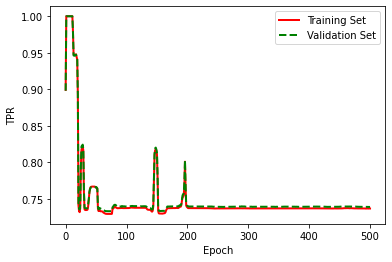


---TPR after the blackbox_detector is retrained (Before retraining MalGAN).

Train_TPR: 1.0, Test_TPR: 1.0
[0.9077272154292197] [0.9044117647058824] 

Training epochs.....
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0


---RF SameTrainData

Orig

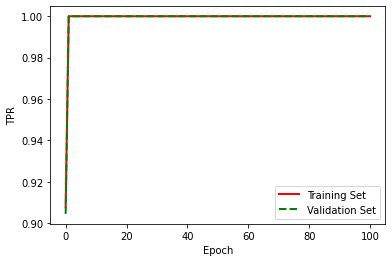

In [ ]:
botgan_RF = BotGAN(blackbox='RF')
botgan_RF.train(epochs=500, batch_size=4096)
botgan_RF.retrain_blackbox_detector()
botgan_RF.train(epochs=100, batch_size=4096, is_first=False)

Model: "substitute_detector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 53)]              0         
_________________________________________________________________
dense (Dense)                (None, 256)               13824     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 14,081
Trainable params: 14,081
Non-trainable params: 0
_________________________________________________________________
Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)    

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[0.9441888314635069] [0.940514705882353] 

Training epochs.....
0.8487961679062146 0.8491911764705883
0 [D loss: 0.459081, acc.: 81.7871%] [G loss: 1.475331]
0.8784822891718139 0.8825
1 [D loss: 0.439162, acc.: 80.8105%] [G loss: 1.632537]
0.5855918315895626 0.5899264705882353
2 [D loss: 0.379205, acc.: 79.8828%] [G loss: 1.198922]
0.7619752930795411 0.7638235294117647
3 [D loss: 0.364697, acc.: 83.7891%] [G loss: 1.550770]
0.35966847346527164 0.3669117647058823
4 [D loss: 0.324916, acc.: 88.0249%] [G loss: 1.778540]
0.32402621958905836 0.32419117647058826
5 [D loss: 0.316625, acc.: 88.6230%] [G loss: 1.817540]
0.41645657380562207 0.41816176470588234
6 [D loss: 0.293835, acc.: 88.4521%] [G loss: 1.846041]
0.4186940627757469 0.4199264705882353
7 [D loss: 0.282624, acc.: 89.9902%] [G loss: 2.107635]
0.4156687255767049 0.4168382352941176
8 [D loss: 0.274910, acc.: 90.4541%] [G loss: 2.356162]
0.36341863103491745 0.3640441176470588
9 [D loss: 0.262569, acc.: 90.6494%] [G loss: 2.267997]
0.

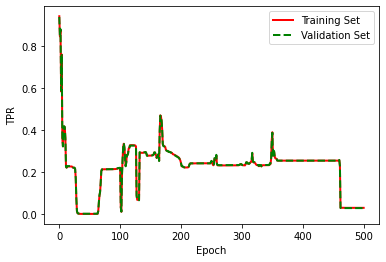

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



---TPR after the blackbox_detector is retrained (Before retraining MalGAN).

Train_TPR: 1.0, Test_TPR: 1.0
[0.9413210639102483] [0.9393382352941176] 

Training epochs.....
1.0 1.0
1.0 1.0
1.0 1.0
0.9999684860708433 0.9999264705882352
0.9997794024959031 0.9997058823529412
0.9996533467792764 0.9996323529411765
0.9946111181142064 0.9932352941176471
0.99476868775999 0.9934558823529411
0.99486322954746 0.9934558823529411
0.9945480902558931 0.9930882352941176
0.994264464893483 0.9925735294117647
0.9936972141686625 0.9923529411764705
0.9921215177108282 0.9903676470588235
0.9915227530568511 0.9888970588235294
0.9902306819614269 0.9873529411764705
0.9829824782553889 0.9805147058823529
0.9574246817093155 0.9546323529411764
0.9491995461994202 0.9461029411764705
0.9484432118996596 0.9454411764705882
0.9484747258288163 0.9452205882352941
0.948096558678936 0.9453676470588235
0.9476868775998991 0.9447794117647059
0.8443527038951216 0.8427941176470588
0.8328501197529308 0.8314705882352941
0.894806504

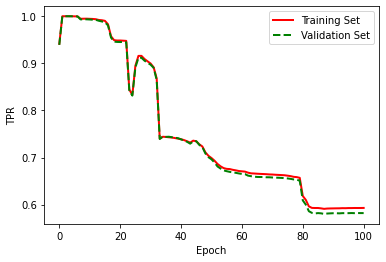

In [ ]:
botgan_MLP = BotGAN(blackbox='MLP')
botgan_MLP.train(epochs=500, batch_size=4096)
botgan_MLP.retrain_blackbox_detector()
botgan_MLP.train(epochs=100, batch_size=4096, is_first=False)

Model: "substitute_detector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 53)]              0         
_________________________________________________________________
dense (Dense)                (None, 256)               13824     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 14,081
Trainable params: 14,081
Non-trainable params: 0
_________________________________________________________________
Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)    

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[0.9208685238875584] [0.92] 

Training epochs.....
0.0717257027606202 0.06816176470588235
0 [D loss: 0.413007, acc.: 88.3423%] [G loss: 0.031979]
0.0919576452792134 0.08948529411764707
1 [D loss: 0.329775, acc.: 89.6240%] [G loss: 0.238380]
0.05237615025841422 0.049852941176470586
2 [D loss: 0.309988, acc.: 89.3433%] [G loss: 0.112922]
0.0043489222236228415 0.0041911764705882355
3 [D loss: 0.200758, acc.: 93.4570%] [G loss: 0.137913]
0.00025211143325349803 0.00022058823529411765
4 [D loss: 0.159813, acc.: 94.7266%] [G loss: 0.036419]
0.00018908357494012352 0.00014705882352941175
5 [D loss: 0.152901, acc.: 94.5190%] [G loss: 0.034910]
0.00018908357494012352 0.00014705882352941175
6 [D loss: 0.129753, acc.: 95.0195%] [G loss: 0.016246]
3.1513929156687254e-05 0.0
7 [D loss: 0.131096, acc.: 94.5801%] [G loss: 0.041220]
3.1513929156687254e-05 0.0
8 [D loss: 0.117651, acc.: 95.2393%] [G loss: 0.043824]
3.1513929156687254e-05 0.0
9 [D loss: 0.118494, acc.: 94.9097%] [G loss: 0.033404]
3.15139

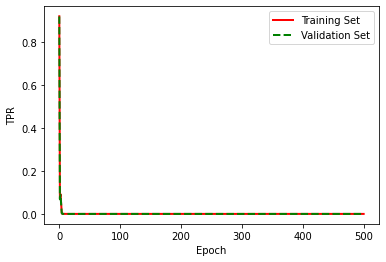

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



---TPR after the blackbox_detector is retrained (Before retraining MalGAN).

Train_TPR: 1.0, Test_TPR: 1.0
[0.921404260683222] [0.9211029411764706] 

Training epochs.....
0.9928778520105886 0.9935294117647059
0.9869217193999748 0.9877941176470588
1.0 1.0
1.0 1.0
1.0 1.0
0.999495777133493 0.9998529411764706
0.9984558174713223 0.9983823529411765
0.994453548468423 0.9952205882352941
0.9944220345392664 0.995
0.9943905206101097 0.995
0.9943905206101097 0.995
0.9943905206101097 0.995
0.9943905206101097 0.995
0.9943905206101097 0.9949264705882352
0.9943905206101097 0.9949264705882352
0.9943905206101097 0.9949264705882352
0.9943905206101097 0.995
0.9943905206101097 0.995
0.9943905206101097 0.9949264705882352
0.9943905206101097 0.9949264705882352
0.9943905206101097 0.9949264705882352
0.9943905206101097 0.9949264705882352
0.994359006680953 0.9949264705882352
0.9943905206101097 0.9949264705882352
0.9943905206101097 0.995
0.9943905206101097 0.9949264705882352
0.9943905206101097 0.9948529411764706

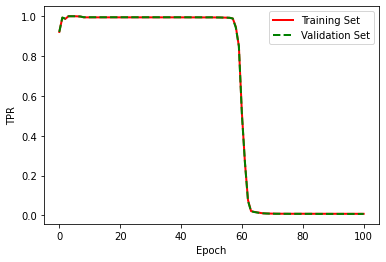

In [ ]:
botgan_LR = BotGAN(blackbox='LR')
botgan_LR.train(epochs=500, batch_size=4096)
botgan_LR.retrain_blackbox_detector()
botgan_LR.train(epochs=100, batch_size=4096, is_first=False)

Model: "substitute_detector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 53)]              0         
_________________________________________________________________
dense (Dense)                (None, 256)               13824     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 14,081
Trainable params: 14,081
Non-trainable params: 0
_________________________________________________________________
Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)    

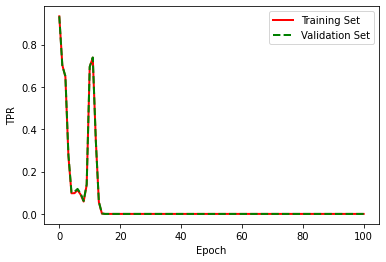


---TPR after the blackbox_detector is retrained (Before retraining MalGAN).

Train_TPR: 1.0, Test_TPR: 1.0
[0.9325601916046893] [0.9293382352941176] 

Training epochs.....
0.9999369721416866 1.0
0.36058237741081556 0.34823529411764703
0.24190092020673137 0.2336029411764706
0.2344321189965965 0.2248529411764706
0.23260431110550864 0.2236029411764706
0.2319110046640615 0.22308823529411764
0.23175343501827808 0.2223529411764706
0.23106012857683095 0.22220588235294117
0.2309971007185176 0.2222794117647059
0.23263582503466532 0.22345588235294117
0.23600781545443086 0.2263235294117647
0.23720534476238497 0.22801470588235295
0.23774108155804866 0.22830882352941176
0.23783562334551872 0.22838235294117648
0.23767805369973527 0.22838235294117648
0.23767805369973527 0.22808823529411765
0.23758351191226523 0.22823529411764706
0.23755199798310853 0.22816176470588234
0.23748897012479517 0.22801470588235295
0.23745745619563846 0.22801470588235295
0.23736291440816842 0.22801470588235295
0.23733140047

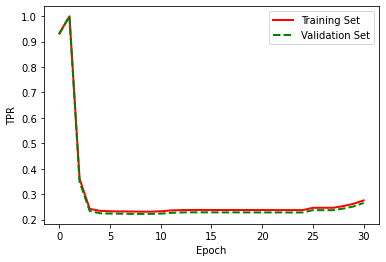

In [ ]:
botgan_SVM = BotGAN(blackbox='SVM')
botgan_SVM.train(epochs=100, batch_size=4096)
botgan_SVM.retrain_blackbox_detector()
botgan_SVM.train(epochs=30, batch_size=4096, is_first=False)

In [ ]:
botgan_GBC = BotGAN(blackbox='GBC')
botgan_GBC.train(epochs=500, batch_size=4096)
botgan_GBC.retrain_blackbox_detector()
botgan_GBC.train(epochs=100, batch_size=4096, is_first=False)

In [ ]:
botgan_KNC = BotGAN(blackbox='KNC')
botgan_KNC.train(epochs=100, batch_size=4096)
botgan_KNC.retrain_blackbox_detector()
botgan_KNC.train(epochs=30, batch_size=4096, is_first=False)

NameError: ignored

Model: "substitute_detector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 53)]              0         
_________________________________________________________________
dense (Dense)                (None, 256)               13824     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 14,081
Trainable params: 14,081
Non-trainable params: 0
_________________________________________________________________
Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)    

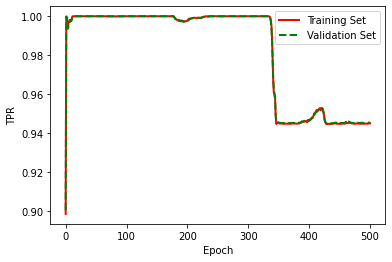


---TPR after the blackbox_detector is retrained (Before retraining MalGAN).

Train_TPR: 1.0, Test_TPR: 1.0
[0.9103113576200681] [0.9133823529411764] 

Training epochs.....
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0


---RF DiffTrainData

Orig

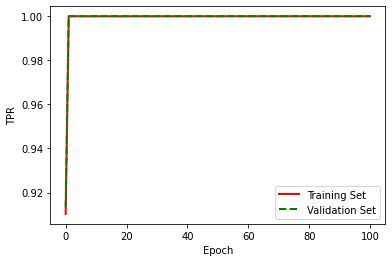

In [6]:
botgan_RF_0 = BotGAN(blackbox='RF', same_train_data=0)
botgan_RF_0.train(epochs=500, batch_size=4096)
botgan_RF_0.retrain_blackbox_detector()
botgan_RF_0.train(epochs=100, batch_size=4096, is_first=False)

Model: "substitute_detector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 53)]              0         
_________________________________________________________________
dense (Dense)                (None, 256)               13824     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 14,081
Trainable params: 14,081
Non-trainable params: 0
_________________________________________________________________
Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)    

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[0.9411319803353082] [0.9453676470588235] 

Training epochs.....
0.7911887054077903 0.793235294117647
0 [D loss: 0.551415, acc.: 80.8105%] [G loss: 2.032001]
0.6638094037564604 0.6653676470588236
1 [D loss: 0.506102, acc.: 76.2817%] [G loss: 1.525663]
0.6270011345014497 0.629264705882353
2 [D loss: 0.497881, acc.: 73.4009%] [G loss: 1.288942]
0.5382579099962184 0.5420588235294118
3 [D loss: 0.446294, acc.: 77.1973%] [G loss: 1.439190]
0.45090129837388127 0.45691176470588235
4 [D loss: 0.390352, acc.: 83.0688%] [G loss: 0.995255]
0.21183663179125173 0.21654411764705883
5 [D loss: 0.307136, acc.: 88.9160%] [G loss: 0.514360]
0.10670616412454305 0.11036764705882353
6 [D loss: 0.251366, acc.: 90.1733%] [G loss: 0.420517]
0.0546451531576957 0.060294117647058824
7 [D loss: 0.207142, acc.: 92.9443%] [G loss: 0.419554]
0.1070843312744233 0.11360294117647059
8 [D loss: 0.191933, acc.: 93.0176%] [G loss: 0.454196]
0.09775620824404387 0.10308823529411765
9 [D loss: 0.169155, acc.: 94.6167%] [G lo

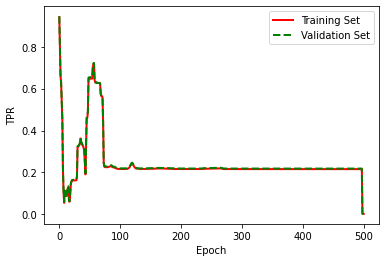

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



---TPR after the blackbox_detector is retrained (Before retraining MalGAN).

Train_TPR: 1.0, Test_TPR: 1.0
[0.9259422664817849] [0.9284558823529412] 

Training epochs.....
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.997983108533972 0.99875
0.9945165763267364 0.9949264705882352
0.9935081305937224 0.9944117647058823
0.9928778520105886 0.9935294117647059
0.9932560191604689 0.9938970588235294
0.992940879868902 0.99375
0.9907979326862473 0.9916176470588235
0.9847472582881633 0.9863970588235295
0.9825412832471953 0.9830882352941176
0.9841169797050296 0.9852941176470589
0.9953359384848103 0.9956617647058823
0.9967225513677045 0.9968382352941176
0.9967225513677045 0.9969117647058824
0.9965964956510778 0.996985294117647
0.9965964956510778 0.9968382352941176
0.9966595235093911 0.9968382352941176
0.9965964956510778 0.9966911764705882
0.9958401613513173 0.9956617647058823
0.9962183285011975 0.99625
0.9950838270515567 0.99536764

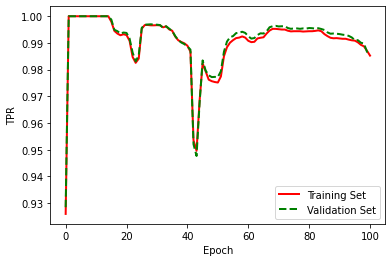

In [3]:
botgan_MLP_0 = BotGAN(blackbox='MLP', same_train_data=0)
botgan_MLP_0.train(epochs=500, batch_size=4096)
botgan_MLP_0.retrain_blackbox_detector()
botgan_MLP_0.train(epochs=100, batch_size=4096, is_first=False)